In [1]:
import pandas as pd
import finterstellar as fs

데이터 로딩

In [2]:
coin = fs.CoinPrice()

In [3]:
p_cd = ['BTC', 'ETH', 'XRP', 'BCH']

In [4]:
prices_df = pd.DataFrame()
for cd in p_cd:
    df = coin.bithumb_historical_price(coin_cd=cd, freq='M')
    prices_df[cd] = df['close']
prices_df.head()

,BTC,ETH,XRP,BCH
2019-04-27 16:45:00,6116000.0,182000.0,354.0,NaN
2019-04-27 16:46:00,6115000.0,182300.0,354.0,307900.0
2019-04-27 16:47:00,6112000.0,182300.0,353.0,308000.0
2019-04-27 16:50:00,6112000.0,182100.0,354.0,NaN
2019-04-27 16:51:00,6111000.0,NaN,354.0,307600.0


In [5]:
prices_df = prices_df.fillna(method='ffill')
prices_df = prices_df.dropna()
prices_df.head()

,BTC,ETH,XRP,BCH
2019-04-27 16:46:00,6115000.0,182300.0,354.0,307900.0
2019-04-27 16:47:00,6112000.0,182300.0,353.0,308000.0
2019-04-27 16:50:00,6112000.0,182100.0,354.0,308000.0
2019-04-27 16:51:00,6111000.0,182100.0,354.0,307600.0
2019-04-27 16:52:00,6113000.0,182100.0,354.0,308000.0


In [6]:
trd = fs.PairTrade()
# fs 라이브러리의 PairsTrade() 모듈을 호출에 trd로 지정

기준일자 세팅

In [7]:
# 기준일자 세팅
base_date = prices_df.index[0]
base_date

'2019-04-27 16:46:00'

R2 값 비교

In [8]:
comp_r2 = trd.compare_r2(prices_df, base_date, p_cd)
'''
    compare_r2(데이터프레임, 기준일자, [종목코드군]) 
    - [종목코드군] 내 종목 쌍 전체에 대해 회귀분석을 수행해서 R2 값 순서대로 결과 반환
'''
comp_r2.head(10)

,R2,Slope,Correlation
pair,,,
BTC vs. ETH,67.19,0.0799,0.819722
XRP vs. BCH,49.83,795.0835,0.705879
ETH vs. BCH,47.55,0.7134,0.689569
ETH vs. XRP,36.91,0.0006,0.607550
BTC vs. BCH,35.14,0.0598,0.592785
BTC vs. XRP,24.48,0.0000,0.494767


데이터구간 샘플링

In [9]:
pair = ['BTC', 'ETH']
sample = trd.sampling(prices_df, base_date, pair)
# sampling(데이터프레임, 기준일자, [종목명]) - 데이터프레임에서 지정한 종목의 기준일자 이후 데이터만 샘플링

회귀분석 수행

In [10]:
regr = trd.regression(sample, pair)
# regression(데이터프레임, [종목쌍]) - 데이터프레임의 종목쌍에 대해 회귀분석을 수행해 기울기, y절편, R2값 반환
regr

{'Slope': 0.07989001376007204,
 'Intercept': -305164.13044863835,
 'R2': 0.6719440671403573}

BTC가 x 일때 추세선에 따른 ETH가 얼마이어야 하는지 구함

In [11]:
sample = trd.expected_y(sample, regr, pair)
# expected_y(데이터프레임, 회귀분석결과, [종목쌍]) - 회귀분석결과를 집어넣고 통계적인 y종목의 기대가격을 산출
sample.head()

,BTC,ETH,ETH expected,ETH spread
2019-04-27 16:46:00,6115000.0,182300.0,183363.303694,-1063.303694
2019-04-27 16:47:00,6112000.0,182300.0,183123.633653,-823.633653
2019-04-27 16:50:00,6112000.0,182100.0,183123.633653,-1023.633653
2019-04-27 16:51:00,6111000.0,182100.0,183043.743639,-943.743639
2019-04-27 16:52:00,6113000.0,182100.0,183203.523667,-1103.523667


역치 세팅

In [12]:
# trading strategy determinants
threshold = 0.005   # percent 값으로 오차허용 구간을 정의
sample = trd.price_analyze(sample, threshold, pair)
# price_analyze(데이터프레임, 역치, [종목쌍]) - 역치값 대비 현재 가격의 고평가/저평가 여부 구분

         BTC  ETH  ETH expected  ETH spread
cheaper                                    
BTC      144  144           144         144
E        837  837           837         837
ETH      139  139           139         139


# 백테스팅

트레이드북 생성

In [13]:
book = trd.create_trade_book(sample, pair)
# create_trade_book(데이터프레임, [종목쌍]) - 트레이딩북 생성
book.head()

,BTC,ETH,t BTC,p BTC,t ETH,p ETH
2019-04-27 16:46:00,6115000.0,182300.0,,,,
2019-04-27 16:47:00,6112000.0,182300.0,,,,
2019-04-27 16:50:00,6112000.0,182100.0,,,,
2019-04-27 16:51:00,6111000.0,182100.0,,,,
2019-04-27 16:52:00,6113000.0,182100.0,,,,


매일매일의 매매내역 기록

In [14]:
book = trd.tradings(sample, book, threshold, pair, short=False)
# tradings(데이터프레임, 트레이딩북, 역치, [종목코드쌍], 숏가능) - pair trade 매매전략을 이용한 백테스팅 수행

일자별 포지션 기록

In [15]:
book = trd.position(book, pair)
# position(트레이딩북, 종목코드) - 트레이딩 전략 수행에 수반되는 포지션 판단
book.tail()

,BTC,ETH,t BTC,p BTC,t ETH,p ETH
2019-04-28 16:39:00,6135000.0,184300.0,,zz,,zz
2019-04-28 16:40:00,6134000.0,184300.0,,zz,,zz
2019-04-28 16:41:00,6142000.0,184500.0,,zz,buy,zl
2019-04-28 16:42:00,6143000.0,184800.0,,zz,,lz
2019-04-28 16:44:00,6143000.0,184800.0,,zz,,zz


일자별 수익률 및 전체 수익률 계산

In [16]:
fund_rtn = trd.returns(book, pair, display=True)
# returns(트레이딩북, 종목코드) - 전략의 수익률 계산

2019-04-28 02:26:00 long BTC 6116000.0
2019-04-28 02:37:00 long BTC 6116000.0  | unwind long BTC 6122000.0  | return: 1.001
2019-04-28 02:39:00 long BTC 6117000.0
2019-04-28 02:45:00 long BTC 6117000.0  | unwind long BTC 6129000.0  | return: 1.002
2019-04-28 02:47:00 long BTC 6127000.0
2019-04-28 03:33:00 long BTC 6127000.0  | unwind long BTC 6118000.0  | return: 0.9985
2019-04-28 03:34:00 long BTC 6118000.0
2019-04-28 03:37:00 long BTC 6118000.0  | unwind long BTC 6121000.0  | return: 1.0005
2019-04-28 03:39:00 long BTC 6121000.0
2019-04-28 03:40:00 long BTC 6121000.0  | unwind long BTC 6128000.0  | return: 1.0011
2019-04-28 03:41:00 long BTC 6124000.0
2019-04-28 03:43:00 long BTC 6124000.0  | unwind long BTC 6129000.0  | return: 1.0008
2019-04-28 03:44:00 long BTC 6123000.0
2019-04-28 03:47:00 long BTC 6123000.0  | unwind long BTC 6128000.0  | return: 1.0008
2019-04-28 03:49:00 long BTC 6123000.0
2019-04-28 04:19:00 long BTC 6123000.0  | unwind long BTC 6135000.0  | return: 1.002
201

벤치마크 수익률 계산
(여기에서는 두 종목에 50%씩 분산투자하고 기간 중 계속 보유한 것으로 가정)

In [17]:
bm_rtn = trd.benchmark_return(book, pair)
# benchmark_return(트레이딩북, 종목코드) - 벤치마크 수익률 계산

BM return: 0.91 %
{'BTC': 1.0046, 'ETH': 1.0137}


페어트레이딩 전략의 초과수익률 계산

In [18]:
exs_rtn = trd.excess_return(fund_rtn, bm_rtn)
# excess_return(전략수익률, 벤치마크수익률) - 초과수익률 계산

Excess return: 2.52 %


In [19]:
# 참고 : 로그수익률
fund_rtn = trd.returns_log(book, pair)
# returns_log(트레이딩북, 종목코드) - 전략의 로그수익률 계산
bm_rtn = trd.benchmark_return_log(book, pair)
# benchmark_return(트레이딩북, 종목코드) - 벤치마크 수익률 계산
exs_rtn = trd.excess_return_log(fund_rtn, bm_rtn)
# excess_return(전략수익률, 벤치마크수익률) - 초과수익률 계산

Accunulated return : 3.4 %
BM return: 0.91 %
{'BTC': 0.4568, 'ETH': 1.362}
Excess return: 2.49 %


그래프 모듈 호출

In [20]:
v = fs.VisualizeIntraday()

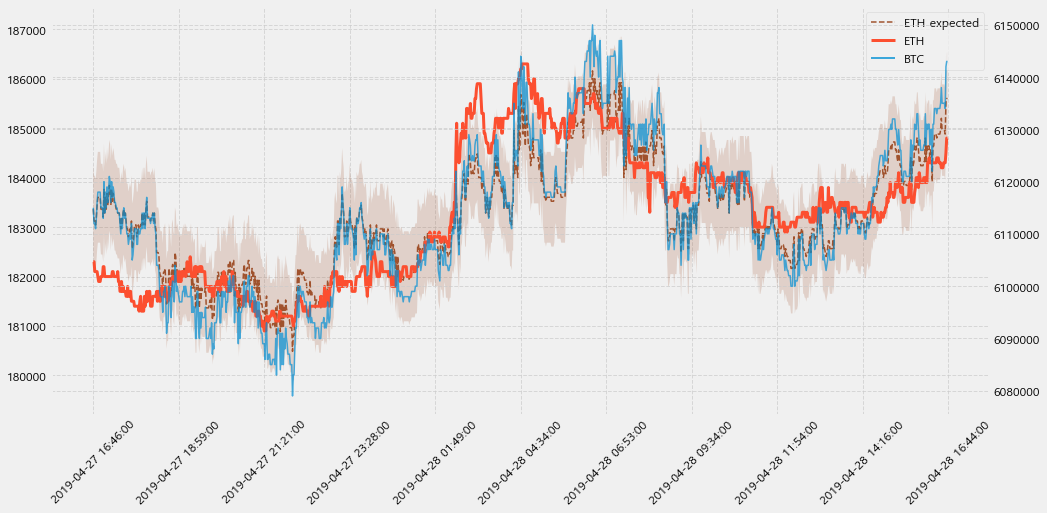

In [21]:
v.pair_trend_index_view(sample, threshold, pair)
# v 모듈의 pairs_trend_index_view(트레이딩북, 역치, [종목코드], (사이즈)) 함수 - pairs trade 그래프 그리기

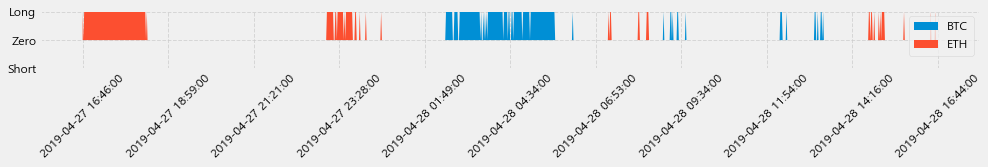

In [22]:
v.position_view(book, pair)
# v 모듈의 position_view(트레이딩북, 종목코드, (사이즈)) 함수 - 보유내역 그래프 그리기

주가 변동 내역

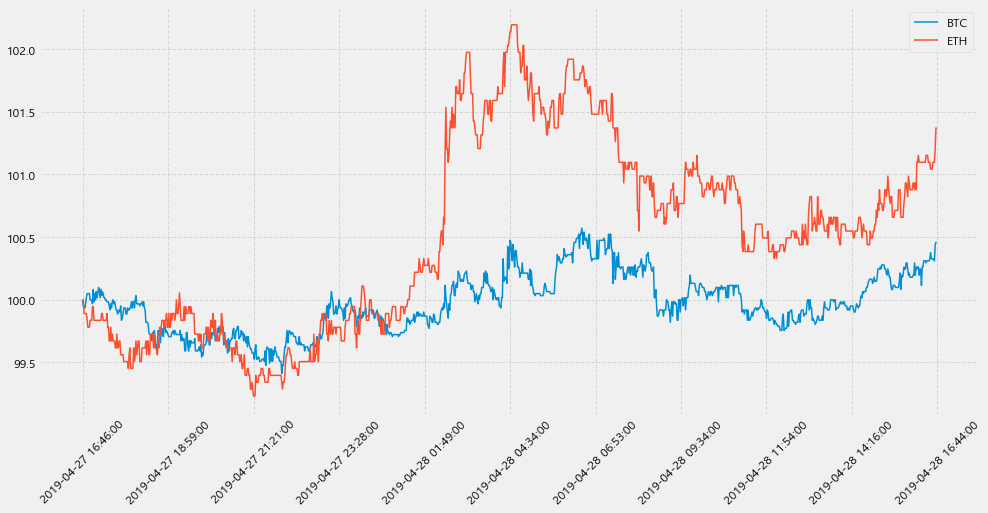

In [23]:
v.index_view(sample, base_date, pair)